In [1]:
from datafetchingirta import DataFetcher
import bhutils as bh
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from importlib import reload

import pysabr
reload(pysabr)
from pysabr import Hagan2002NormalSABR
from fwdsabr.find_fvol import find_fvol, SabrDist
from fwdsabr.option_pricing import compute_option_prices

Loaded
Loaded
Loaded


In [2]:
bh.bhDbAddServer("sql-snap-prod-cm")
ezbh = DataFetcher()

Getting Curves...
Getting Vols
Updating Pricing factory
Creating Risk Factory
Done


In [45]:
generator = 'JPY DYENCALM'
exp = '1Y'
tail = '2Y'
start_date = pd.Timestamp('2000-01-01')
end_date = pd.Timestamp('today')


distribution_df = ezbh.distribution_df(Generator=generator, EffExp=exp, MtyTnr=tail,).dropna()
distribution = ezbh.create_distribution(Generator=generator, EffExp=exp, MtyTnr=tail,)
moments = ezbh.distribution_moments(Generator=generator, EffExp=exp, MtyTnr=tail,)

T = distribution_df['T'].values[0]
strikes_bps = np.array(distribution_df['strike_relative'].values) 
prices_bps = np.array(distribution_df['price_bps'].values)
vols_bps = np.array(distribution_df['vol'].values)

In [46]:
def find_sabr_from_vols(
        strikes_relative_bps,
        vols_bps,
):
    def to_optimize(x, strikes_relative, vols):
        v_atm_n, shift, beta, rho, volvol = x
        # print(x)
        sabr = Hagan2002NormalSABR(
            f=0, shift=shift, t=1, v_atm_n=v_atm_n, beta=beta, rho=rho, volvol=volvol
        )
        vols_computed = sabr.normal_vol(strikes_relative)
        error = ((vols_computed - vols) ** 2).sum() * 10**12
        # print(np.any(np.isnan(vols_computed)))
        # print(vols_computed)
        return error
    optimization_result = minimize(
        to_optimize,
        x0=[0.01, .05, .5, 0.3, 0.2],
        bounds=((0.00001, .1), (0.0001, .2), (.001, .999), (-.999, 0.999), (0.00001, 3)),
        args=(strikes_relative_bps / 10000, vols_bps / 10000,),
        method='Nelder-Mead',
    )
    v_atm_n, shift, beta, rho, volvol = optimization_result.x
    return v_atm_n, shift, beta, rho, volvol

In [47]:
def find_sabr_from_prices(
        strikes_relative_bps,
        prices_rec_bps,
        T,
):
    def to_optimize(x, strikes_relative, prices):
        v_atm_n, shift, beta, rho, volvol = x
        sabr = Hagan2002NormalSABR(
            f=0, shift=shift, t=T, v_atm_n=v_atm_n, beta=beta, rho=rho, volvol=volvol
        )
        vols_computed = sabr.normal_vol(strikes_relative)
        prices_computed = compute_option_prices(
            F=0,
            K=strikes_relative,
            vol=vols_computed,
            T=T,
            call_put='put'
        )
        error = ((prices - prices_computed) ** 2).sum() * 10**12
        return error
    optimization_result = minimize(
        to_optimize,
        x0=[0.01, .05, .5, 0.3, 0.2],
        bounds=((0.00001, .1), (0.0001, .2), (.001, .999), (-.999, 0.999), (0.00001, 3)),
        args=(strikes_relative_bps / 10000, prices_rec_bps / 10000,),
        method='Nelder-Mead',
    )
    v_atm_n, shift, beta, rho, volvol = optimization_result.x
    return Hagan2002NormalSABR(
        f=0, shift=shift, t=1, v_atm_n=v_atm_n, beta=beta, rho=rho, volvol=volvol
    )
    

In [56]:
import pysabr
reload(pysabr)
from pysabr import Hagan2002NormalSABR
sabr = find_sabr_from_prices(
    strikes_relative_bps=distribution_df['strike_relative'].values,
    prices_rec_bps=distribution_df['price_bps'].values,
    T = T
)


Loaded


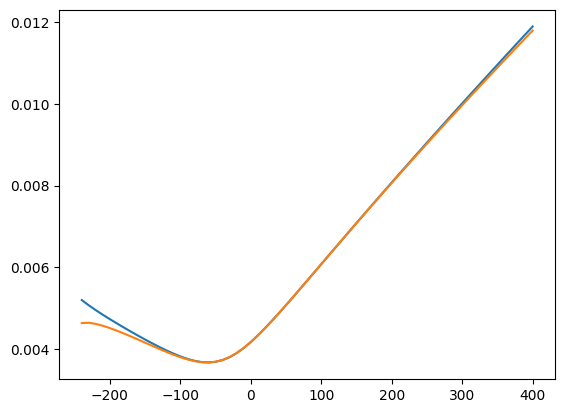

In [57]:
plt.plot(strikes_bps, sabr.normal_vol(k=strikes_bps/10000))
plt.plot(strikes_bps, vols_bps/10000)

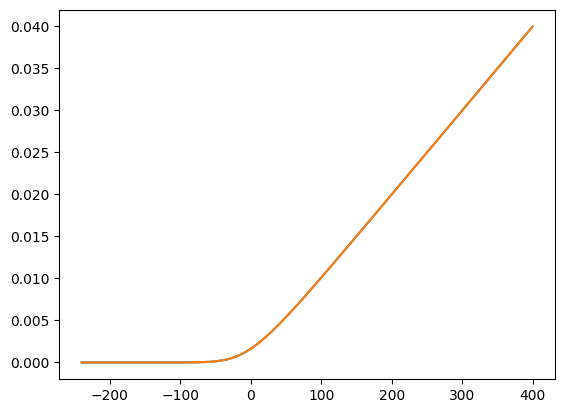

In [58]:
strikes = np.array(distribution_df['strike_relative'])[:]
plt.plot(
    strikes, 
    compute_option_prices(
        F = 0, 
        K = strikes / 10000,
        vol = sabr.normal_vol(k=strikes/10000),
        T=T,
        call_put='put'
        )
)
plt.plot(strikes, distribution_df['price_bps'].values/10000)

In [249]:
sabr = Hagan2002NormalSABR(f = 0, shift=shift, t=1, beta = beta,v_atm_n=v_atm_n, rho=rho, volvol=volvol)
sabr
''

''

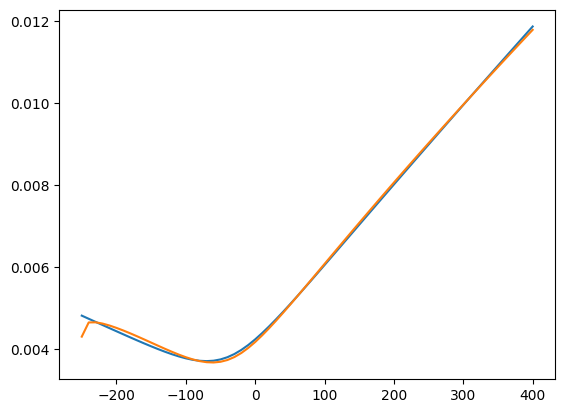

In [252]:
plt.plot(distribution_df['strike_relative'].values, sabr.normal_vol(k=distribution_df['strike_relative'].values/10000))
plt.plot(distribution_df['strike_relative'].values, distribution_df['vol'].values/10000)
